In [11]:
# Installing required dependencies required for the assignment

!pip install lightning -qU
!pip install wandb -qU

In [12]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import torch 
from torch import nn

import lightning as L
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import wandb

from lightning.pytorch.loggers import WandbLogger


In [13]:
# Using Wandb API key, login to wandb account
from kaggle_secrets import UserSecretsClient
api_key = UserSecretsClient().get_secret("wandb_api")

wandb.login(key=api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
#Since Kaggle is used to train the model, we have upload the data at this address.
#In case you are excuting the code, make sure that you have correct directory path of the dataset
dataset_path = "/kaggle/input/dakshina-dataset-v1-0-hi/dakshina_dataset_v1.0_hi/lexicons"

In [15]:
#Creating a custom dataset class in pytorch to store the transliteration dataset.

class TransliterationDataset(Dataset):
    def __init__(self, dataframe, source_vocab, target_vocab):
        self.dataframe = dataframe
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        src_words = [ self.source_vocab[chr] if chr in self.source_vocab else self.source_vocab["<UNK>"] for chr in self.dataframe.iloc[idx]["source"]]

        # Similarly, for the target words        
        tgt_words = [self.target_vocab[chr] if chr in self.target_vocab else self.target_vocab["<UNK>"] for chr in self.dataframe.iloc[idx]["target"]]
        # Add <SOW> and <EOW> tokens to the target words
        tgt_words = [self.target_vocab["<SOW>"]] + tgt_words + [self.target_vocab["<EOW>"]]

        return torch.LongTensor(src_words), torch.LongTensor(tgt_words) 


In [16]:
#Since we are using lightning module, Let's define the Lightning data module to handle the dataset
class TrasnliterationDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size=32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        
        # Load the train dataset
        self.train_df = pd.read_csv(
            f"{self.data_dir}/hi.translit.sampled.train.tsv",
            sep="\t",
            names=["target", "source", "attestations"],
            header=None,
            keep_default_na=False, na_values=[]
        )
        # Drop the attestations column
        self.train_df.drop(columns=["attestations"], inplace=True)

        # Let's load the dev set as well
        # We will use the dev set for validation
        self.dev_df = pd.read_csv(
            f"{self.data_dir}/hi.translit.sampled.dev.tsv",
            sep="\t",
            names=["target", "source", "attestations"],
            header=None,
            keep_default_na=False, na_values=[]
        )
        # Drop the attestations column
        self.dev_df.drop(columns=["attestations"], inplace=True)


        #Let's load the test set as well
        # We will use the test set for evaluation
        self.test_df = pd.read_csv(
            f"{self.data_dir}/hi.translit.sampled.test.tsv",
            sep="\t",
            names=["target", "source", "attestations"],
            header=None,
            keep_default_na=False, na_values=[]
        )
        # Drop the attestations column
        self.test_df.drop(columns=["attestations"], inplace=True)

        # Create vocabularies for source and target languages
        self.source_vocab, self.source_chr_to_idx, self.source_idx_to_char = self.build_vocab(self.train_df['source'].values)
        self.target_vocab, self.target_chr_to_idx, self.target_idx_to_char = self.build_vocab(self.train_df['target'].values)


    def prepare_data(self):
        '''
        According the the Lightning documentation, this method is used to download and prepare the data.
        In our case, we are not downloading any data, dataset can be found at the given data_dir path, but we are preparing the data
        '''
        
        self.train_dataset = self.create_dataset(self.train_df)
        self.dev_dataset = self.create_dataset(self.dev_df)
        self.test_dataset = self.create_dataset(self.test_df)

    def build_vocab(self, words):
        '''
        This method is used to build the vocab for the given data
        :param data: The data to build the vocab for
        :return: The vocab for the given data
        '''
        vocab = set()
        for word in words:
            for char in word:
                vocab.add(char)

        # Adding special tokens in the vocab.
        vocab.add("<UNK>")
        vocab.add("<EOW>")
        vocab.add("<SOW>")

        # Sort the vocab to get the same order every time
        vocab = sorted(vocab)
        
        chr_to_idx_map = { chr : idx+1 for idx, chr in enumerate(vocab) }
        idx_to_chr_map = { idx+1 : chr for idx, chr in enumerate(vocab) }

        chr_to_idx_map["<PAD>"] = 0
        idx_to_chr_map[0] = "<PAD>"

        vocab.append("<PAD>")
        
        return vocab, chr_to_idx_map, idx_to_chr_map

    def create_dataset(self, dataframe):
        '''
        This method is used to create the dataset for the given data
        :param dataframe: The dataframe to create the dataset for
        :return: The dataset for the given data
        '''
        return TransliterationDataset(dataframe, self.source_chr_to_idx, self.target_chr_to_idx)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle=True, collate_fn = self.collate_fn, num_workers=3)
    
    def val_dataloader(self):
        return DataLoader(self.dev_dataset, batch_size = self.batch_size, shuffle=False, collate_fn = self.collate_fn, num_workers=3)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle=False, collate_fn = self.collate_fn, num_workers=3)
    
    def collate_fn(self, batch):
        '''
        This method is used to collate the data into batches
        :param batch: The batch to collate
        :return: The collated batch
        '''
        src_words, tgt_words = zip(*batch)
        
        # Pad the source and target words
        src_words = torch.nn.utils.rnn.pad_sequence(src_words, batch_first=True, padding_value=0)
        tgt_words = torch.nn.utils.rnn.pad_sequence(tgt_words, batch_first=True, padding_value=0)

        return src_words, tgt_words

In [17]:
#In the below cells,we would define the encoder, decoder architecture, 

class Encoder(nn.Module):
    def __init__(self, cell_type, input_embedding_size, embedding_dimension, hidden_layer_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.dropout = dropout

        # Embedding layer
        self.embedding = nn.Embedding(input_embedding_size, embedding_dimension, padding_idx=0)

        # Here while defining the embedding layer, we have set the padding_idx to 0, which is the index of the <PAD> token in our vocab.
        # This means that the embedding layer will ignore the padding tokens when computing the embeddings.
        # The embedding layer will learn the embeddings for the input characters.

        # Encoder RNN cell
        self.rnn_cell = {
            "RNN": nn.RNN,
            "LSTM": nn.LSTM,
            "GRU": nn.GRU
        }.get(cell_type)
        if self.rnn_cell is None:
            raise ValueError("Invalid cell type. Choose 'RNN', 'LSTM' or 'GRU'.")
        self.rnn = self.rnn_cell(embedding_dimension, hidden_layer_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        input = self.embedding(x)
        output, hidden = self.rnn(input)
        return output, hidden

In [18]:
class Decoder(nn.Module):
    def __init__(self, cell_type, output_embedding_size, embedding_dimension, hidden_layer_size, num_layers, dropout):
        super(Decoder, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(output_embedding_size, embedding_dimension, padding_idx=0)

        rnn_cell = {
            "RNN": nn.RNN,
            "LSTM": nn.LSTM,
            "GRU": nn.GRU
        }.get(cell_type)
        if rnn_cell is None:
            raise ValueError("Invalid cell type. Choose 'RNN', 'LSTM' or 'GRU'.")
        
        self.rnn = rnn_cell(embedding_dimension, hidden_layer_size, num_layers, dropout=dropout, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_layer_size, output_embedding_size)

    def forward(self, x, hidden):
        input = self.embedding(x)
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output)
        
        return output, hidden

In [19]:
class Seq2Seq(L.LightningModule):
    def __init__(self, input_embedding_size, output_embedding_size, embedding_dimension, 
                 hidden_layer_size, number_of_layers_encoder, number_of_layers_decoder, 
                 dropout, cell_type, learning_rate, teacher_forcing_ratio=0.5):
        super().__init__()
        self.save_hyperparameters()

        # Initialize encoder and decoder
        self.encoder = Encoder(cell_type, input_embedding_size, embedding_dimension,
                              hidden_layer_size, number_of_layers_encoder, dropout)
        self.decoder = Decoder(cell_type, output_embedding_size, embedding_dimension,
                              hidden_layer_size, number_of_layers_decoder, dropout)
        
        # Loss function ignoring padding
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
        self.learning_rate = learning_rate
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, src, tgt, teacher_forcing_ratio=None):
        batch_size, tgt_len = tgt.size()
        outputs = torch.zeros(batch_size, tgt_len-1, self.hparams.output_embedding_size)
        
        # Encoder forward
        _, hidden = self.encoder(src)
        
        # Initialize decoder hidden state
        if self.hparams.cell_type == 'LSTM':
            decoder_hidden = (hidden[0][:self.hparams.number_of_layers_decoder],
                             hidden[1][:self.hparams.number_of_layers_decoder])
        else:
            decoder_hidden = hidden[:self.hparams.number_of_layers_decoder]
        
        decoder_input = tgt[:, 0].unsqueeze(1)  # Start with SOS token
        
        # Decoder forward
        for t in range(tgt_len-1):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[:, t] = decoder_output.squeeze(1)
            
            # Teacher forcing
            tf_ratio = self.teacher_forcing_ratio if teacher_forcing_ratio is None else teacher_forcing_ratio
            teacher_force = torch.rand(1).item() < tf_ratio
            top1 = decoder_output.argmax(2)
            decoder_input = tgt[:, t+1].unsqueeze(1) if teacher_force else top1
            
        return outputs

    def __shared_step(self, batch, batch_idx, stage):
        src, tgt = batch
        output = self(src, tgt, teacher_forcing_ratio=0 if stage != 'train' else None)
        tgt = tgt.to(output.device)
        loss = self.criterion(output.reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
        self.log(f"{stage}_loss", loss)
        
        # Calculate metrics
        preds = output.argmax(2)
        non_pad = tgt[:, 1:] != 0
        correct = (preds == tgt[:, 1:]) & non_pad
        
        # Token-level accuracy
        token_acc = correct.sum().float() / non_pad.sum()
        self.log(f"{stage}_token_acc", token_acc, prog_bar=True)
        
        # Sequence-level accuracy
        seq_acc = ((preds == tgt[:, 1:]) | ~non_pad).all(dim=1).float().mean()
        self.log(f"{stage}_seq_acc", seq_acc, prog_bar=True)
        
        return loss

    def training_step(self, batch, batch_idx):
        return self.__shared_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self.__shared_step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        return self.__shared_step(batch, batch_idx, "test")

    def predict_step(self, batch, batch_idx):
        src, _ = batch  # Don't require target during prediction
        output = self(src, torch.zeros_like(src), teacher_forcing_ratio=0)
        return output.argmax(2)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [20]:
def create_sweep_name(config):
    return (f"{config.cell_type}_"
            f"encoder_nl_{config.num_layers}_"
            f"decoder_nl_{config.num_layers}_"
            f"embedd_dim_{config.embedd_dim}_"
            f"hidden_size_{config.hidden_size}"
            f"tf_ratio_{config.teacher_force_ratio}_"
            f"lr_{config.lr}_"
            f"dropout_{config.dropout}_"
            f"max_epoches_{config.max_epochs}_"
            f"batch_size_{config.batch_size}")

In [34]:
def main(config = None):
    wandb.init(project = "da6401_assignment3_v1",
               config = config)
    config = wandb.config
    wandb.run.name = create_sweep_name(config)

    wandb_logger = WandbLogger(project = "da6401_assignment2",
                               log_model = True)

    data = TrasnliterationDataModule(dataset_path,batch_size = config.batch_size)
    
    
    model = Seq2Seq(len(data.source_vocab), len(data.target_vocab),embedding_dimension = config.embedd_dim,
                   hidden_layer_size = config.hidden_size, number_of_layers_encoder=config.num_layers, number_of_layers_decoder=config.num_layers, 
                     dropout=config.dropout, cell_type= config.cell_type, learning_rate=config.lr, teacher_forcing_ratio=config.teacher_force_ratio)
    # model = torch.compile(model)

    trainer = L.Trainer(
        logger = wandb_logger,
        # strategy='ddp_spawn',
        max_epochs = config.max_epochs,
        precision="16-mixed",
        # devices = 2,
    )

    trainer.fit(model, data) 
    wandb.finish()

In [39]:
sweep_config = {
    "name": "Hyperparameter Sweep for RNN",
    "method": "bayes",
    "metric": {
        "name": "val_loss",
        "goal": "minimize"
    },
    "parameters": {
        "embedd_dim": {
            "values": [128, 256, 512]
        },
        "hidden_size": {
            "values": [128, 256, 512]
        },
        "num_layers": {
            "values": [1,2,3, 5]
        },
        "dropout": {
            "values": [0,0.2,0.3,0.4]
        },
        "teacher_force_ratio": {
            "values": [0.1, 0.3, 0.5,0.7]
        },
        "cell_type": {
            "value": "RNN"
        },
        "max_epochs":{
            "values":[5,10,15]
        },
        "lr": {
            "distribution": "log_uniform_values",
            "min": 1e-4,
            "max": 1e-2
        },
        "batch_size":{
            "values":[32,64,128]
        }
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 3,
        "max_iter": 20,
        "eta": 2
    }
}

In [40]:
sweep_id = wandb.sweep(sweep_config,project="da6401_assignment3_v1")

Create sweep with ID: buslu54u
Sweep URL: https://wandb.ai/rohitrk06-indian-institute-of-technology-madras/da6401_assignment3/sweeps/buslu54u


In [ ]:
wandb.agent(sweep_id,main,count=30)

wandb: Agent Starting Run: 8vidzcem with config:
wandb: 	cell_type: RNN
wandb: 	dropout: 0.4
wandb: 	embedd_dim: 32
wandb: 	hidden_size: 32
wandb: 	lr: 0.0008468229385413331
wandb: 	max_epochs: 10
wandb: 	num_layers: 1
wandb: 	teacher_force_ratio: 0.7


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type             | Params | Mode 
----

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
# After performing a hyperparameter sweep, 
# Let's use the best hyperparameters to train the model and evaluate the model on the test set.
batch_size = 128
embbed_dim = 512
hidden_size = 512
num_layers = 5
dropout = 0.4
cell_type = "GRU"
lr = 0.00025
teacher_force_ratio = 0.3
max_epochs = 15

data = TrasnliterationDataModule(dataset_path,batch_size = batch_size)
model = Seq2Seq(len(data.source_vocab), len(data.target_vocab), embedding_dimension = embbed_dim,
               hidden_layer_size= hidden_size, number_of_layers_encoder = num_layers,number_of_layers_decoder=num_layers, 
                     dropout=dropout, cell_type= cell_type, learning_rate=lr, teacher_forcing_ratio=teacher_force_ratio)

wandb_logger = WandbLogger(project = "da6401_assignment3",
                               log_model = True)

trainer = L.Trainer(
    logger = wandb_logger,
    # strategy='ddp_spawn',
    max_epochs = max_epochs,
    precision="16-mixed",
    # devices = 2,
)
trainer.fit(model, data)
# wandb.finish()

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | encoder   | Encoder          | 7.9 M  | train
1 | decoder   | Decoder          | 7.9 M  | train
2 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
15.8 M    Trainable params
0         Non-trainable params
15.8 M    Total params
63.374    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.


epoch,▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
train_loss,██▇▇▇▆▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁
train_seq_acc,▁▁▁▁▁▂▂▃▃▃▄▄▄▄▅▄▅▅▅▅▆▆▆▆▆▆▆▆▇█▆▇▇▇█▇██▇▇
train_token_acc,▁▁▁▂▂▅▅▆▆▆▆▆▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇██▇▇█▇██▇███
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁
val_seq_acc,▁▂▄▆▆▇▇▇▇▇█████
val_token_acc,▁▄▆▇▇▇▇████████
epoch,14
train_loss,0.36559
train_seq_acc,0.58594


In [27]:
trainer = L.Trainer(
    # logger = wandb_logger,
    # strategy='ddp_spawn',
    max_epochs = max_epochs,
    precision="16-mixed",
    # devices = 2,
)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [28]:
trainer.test(model, data)

2025-05-21 10:15:56.165085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747822556.715109      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747822556.857634      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.9469231963157654     │
│       test_seq_acc        │    0.40226566791534424    │
│      test_token_acc       │    0.7485690712928772     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9469231963157654,
  'test_token_acc': 0.7485690712928772,
  'test_seq_acc': 0.40226566791534424}]

In [29]:
def decode_sequence(tensor, chr2idx, idx2char):
    chars = []
    for idx in tensor:
        if idx.item() in [chr2idx['<EOW>'], chr2idx['<PAD>']]:
            break
        chars.append(idx2char.get(idx.item(), '<UNK>'))
    return ''.join(chars)

In [30]:
import os
import random


wandb.init(project="da6401_assignment3_v1", name="predictions_vanilla", job_type="test_evaluation")

data.prepare_data()
test_dataloader = data.test_dataloader()
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create predictions directory
os.makedirs('predictions_vanilla', exist_ok=True)


# For wandb logging
sample_table = wandb.Table(columns=["Source", "Target", "Prediction"])

# Test evaluation
predictions = []
with torch.no_grad(), open('predictions_vanilla/test_predictions.csv', 'w') as f:
    f.write("Source,Target,Prediction\n")
    
    for batch in test_dataloader:
        src, tgt = batch
        src, tgt = src.to(device), tgt.to(device)
        outputs = model(src, tgt, teacher_forcing_ratio=0)
        preds = outputs.argmax(dim=2)
        
        # Decode sequences
        for i in range(src.size(0)):
            source_str = decode_sequence(src[i], data.source_chr_to_idx, data.source_idx_to_char)
            target_str = decode_sequence(tgt[i][1:], data.target_chr_to_idx, data.target_idx_to_char)  # Skip <SOW>
            pred_str = decode_sequence(preds[i],  data.target_chr_to_idx, data.target_idx_to_char)
            
            f.write(f'"{source_str}","{target_str}","{pred_str}"\n')
            predictions.append((source_str, target_str, pred_str))

            # Add a few (e.g. 20) predictions to W&B table
            if len(sample_table.data) < 40 and random.random()<0.02:
                sample_table.add_data(source_str, target_str, pred_str)

# Log the table to wandb
wandb.log({"Sample Test Predictions": sample_table})
wandb.finish()

print("Predictions saved to predictions_vanilla/test_predictions.csv")

Predictions saved to predictions_vanilla/test_predictions.csv


/tmp/ipykernel_35/3073312040.py:39: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3073312040.py:39: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_35/3073312040.py:39: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3073312040.py:39: UserWarning: Glyph 2373 (\N{DEVANAGARI VOWEL SIGN CANDRA E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3073312040.py:39: UserWarning: Glyph 2320 (\N{DEVANAGARI LETTER AI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3073312040.py:39: UserWarning: Glyph 2377 (\N{DEVANAGARI VOWEL SIGN CANDRA O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3073312040.py:39: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3073312040.p

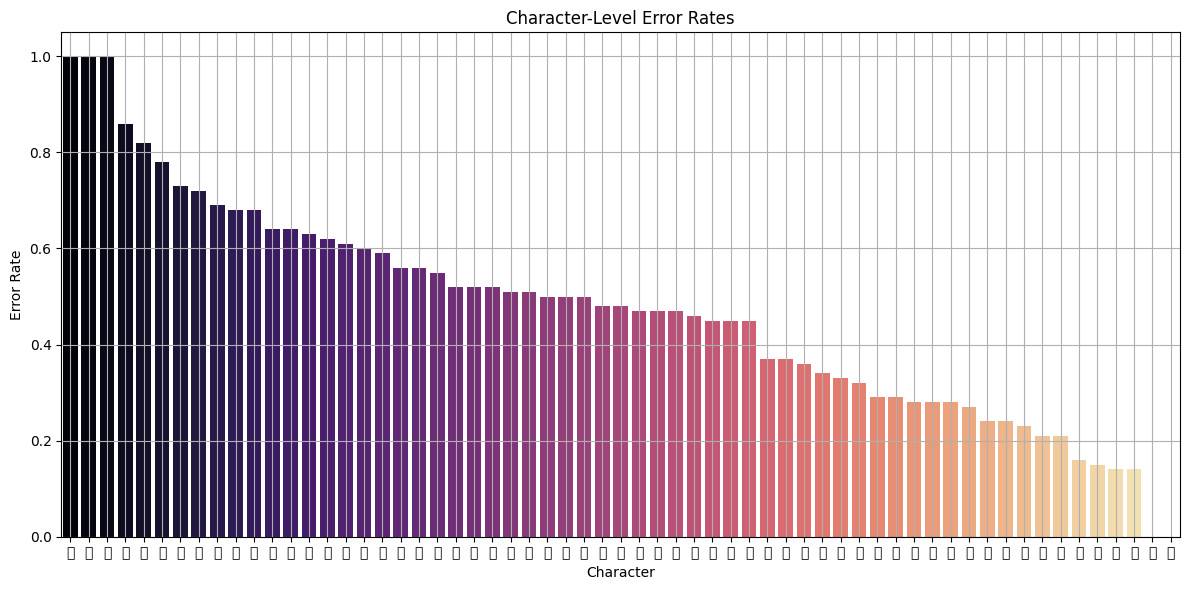

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


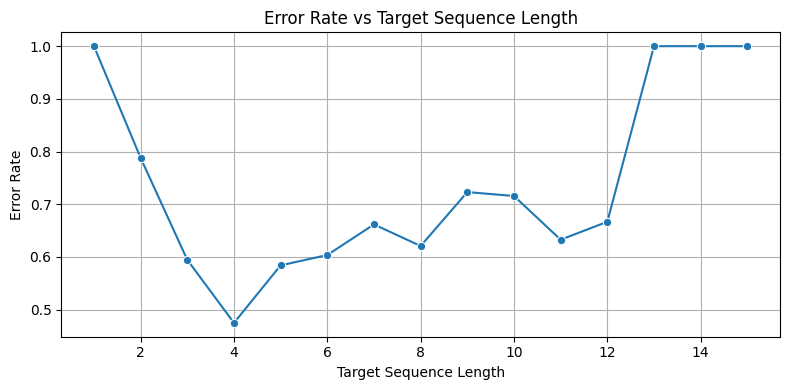

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages

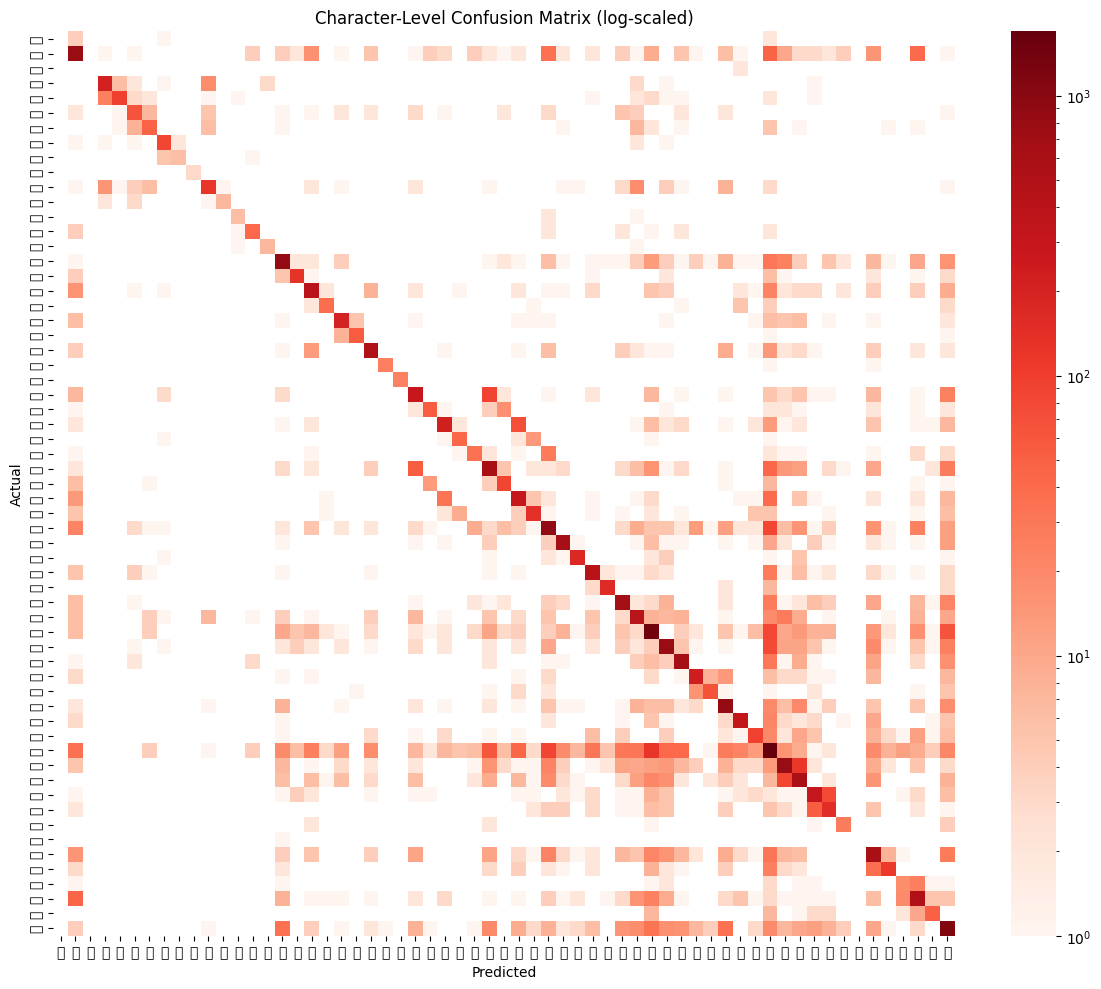


Top 20 Most Confused Character Pairs:
ा → र: 127 times
ि → ी: 116 times
ट → त: 88 times
ा → न: 87 times
ी → ि: 85 times
न → ा: 83 times
र → ा: 82 times
ु → ू: 79 times
ल → ा: 76 times
ड → द: 73 times
र → ्: 65 times
ा → त: 61 times
त → ट: 52 times
ू → ु: 52 times
ं → ा: 47 times
ो → ं: 45 times
ा → द: 44 times
त → ा: 43 times
ा → ल: 42 times
ा → व: 42 times


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix

# Load data
df = pd.read_csv("/kaggle/working/predictions_vanilla/test_predictions.csv")
df["Correct"] = df["Target"] == df["Prediction"]
df["TargetLength"] = df["Target"].apply(len)

# ────────────────────────────────
# 1. Character-level error rates
# ────────────────────────────────
char_errors = Counter()
total_chars = Counter()

for _, row in df[~df["Correct"]].iterrows():
    tgt, pred = row["Target"], row["Prediction"]
    for i in range(min(len(tgt), len(pred))):
        total_chars[tgt[i]] += 1
        if tgt[i] != pred[i]:
            char_errors[tgt[i]] += 1
    for i in range(len(pred), len(tgt)):
        total_chars[tgt[i]] += 1
        char_errors[tgt[i]] += 1

char_error_rates = {c: round(char_errors[c] / total_chars[c], 2) for c in total_chars}
char_error_df = pd.DataFrame(sorted(char_error_rates.items(), key=lambda x: x[1], reverse=True), columns=["Character", "ErrorRate"])

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=char_error_df, x="Character", y="ErrorRate", palette="magma")
plt.title("Character-Level Error Rates")
plt.xlabel("Character")
plt.ylabel("Error Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# ────────────────────────────────
# 2. Error rate vs sequence length
# ────────────────────────────────
length_error = df.groupby("TargetLength")["Correct"].apply(lambda x: 1 - x.mean()).reset_index()
length_error.columns = ["TargetLength", "ErrorRate"]

plt.figure(figsize=(8, 4))
sns.lineplot(data=length_error, x="TargetLength", y="ErrorRate", marker="o")
plt.title("Error Rate vs Target Sequence Length")
plt.xlabel("Target Sequence Length")
plt.ylabel("Error Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# ────────────────────────────────
# 3. Confusion Matrix (Characters)
# ────────────────────────────────
actual_chars = []
pred_chars = []

for _, row in df.iterrows():
    tgt, pred = row["Target"], row["Prediction"]
    for i in range(min(len(tgt), len(pred))):
        actual_chars.append(tgt[i])
        pred_chars.append(pred[i])

# Labels
labels = sorted(set(actual_chars + pred_chars))
cm = confusion_matrix(actual_chars, pred_chars, labels=labels)

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap="Reds", norm=plt.matplotlib.colors.LogNorm())
plt.title("Character-Level Confusion Matrix (log-scaled)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ────────────────────────────────
# 4. Top-N Most Confused Character Pairs
# ────────────────────────────────
confusion_pairs = []

for i, a in enumerate(labels):
    for j, p in enumerate(labels):
        if a != p and cm[i, j] > 0:
            confusion_pairs.append((a, p, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nTop 20 Most Confused Character Pairs:")
for a, p, count in confusion_pairs[:20]:
    print(f"{a} → {p}: {count} times")


Character-level error rates:
'ः': 1.00
'ँ': 1.00
'ॅ': 1.00
'ऐ': 0.86
'ॉ': 0.82
'ण': 0.78
'़': 0.73
'ू': 0.72
'ऊ': 0.69
'ई': 0.68
'ए': 0.68
'ा': 0.64
'ै': 0.64
'ी': 0.63
'ओ': 0.62
'ष': 0.61
'ौ': 0.60
'े': 0.59
'इ': 0.56
'ठ': 0.56
'ट': 0.55
'ं': 0.52
'ो': 0.52
'आ': 0.52
'थ': 0.51
'ड': 0.51
'त': 0.50
'ऑ': 0.50
'औ': 0.50
'य': 0.48
'ृ': 0.48
'द': 0.47
'न': 0.47
'ढ': 0.47
'घ': 0.46
'ि': 0.45
'ु': 0.45
'ध': 0.45
'्': 0.37
'ल': 0.37
'र': 0.36
'श': 0.34
'ग': 0.33
'ख': 0.32
'क': 0.29
'ह': 0.29
'म': 0.28
'च': 0.28
'छ': 0.28
'स': 0.27
'ब': 0.24
'व': 0.24
'ज': 0.23
'अ': 0.21
'भ': 0.21
'फ': 0.16
'प': 0.15
'झ': 0.14
'उ': 0.14
'ञ': 0.00
'ऋ': 0.00


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


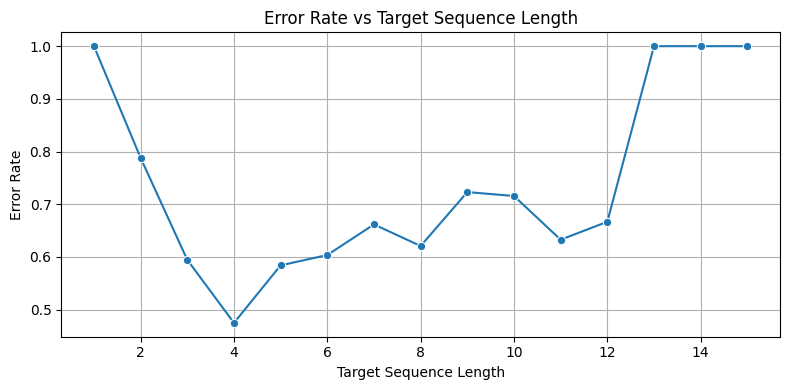

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages

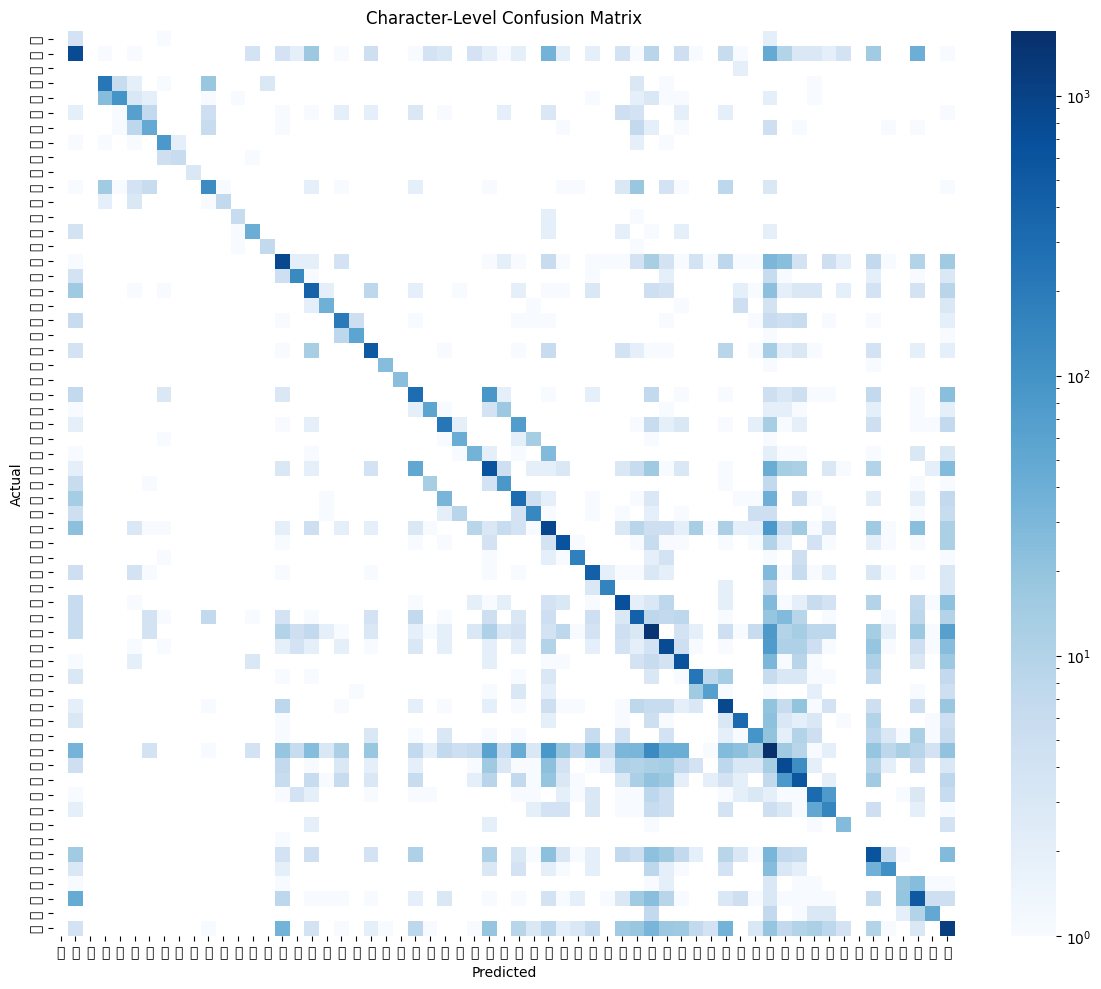

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load data
df = pd.read_csv("/kaggle/working/predictions_vanilla/test_predictions.csv")

# Add correctness and sequence lengths
df["Correct"] = df["Target"] == df["Prediction"]
df["SourceLength"] = df["Source"].apply(len)
df["TargetLength"] = df["Target"].apply(len)

# ────────────────────────────────
# 1. Character-level error rates
# ────────────────────────────────
char_errors = Counter()
total_chars = Counter()

for _, row in df[~df["Correct"]].iterrows():
    tgt, pred = row["Target"], row["Prediction"]
    for i in range(min(len(tgt), len(pred))):
        total_chars[tgt[i]] += 1
        if tgt[i] != pred[i]:
            char_errors[tgt[i]] += 1
    for i in range(len(pred), len(tgt)):
        total_chars[tgt[i]] += 1
        char_errors[tgt[i]] += 1

char_error_rates = {c: round(char_errors[c] / total_chars[c], 2) for c in total_chars}
sorted_char_errors = dict(sorted(char_error_rates.items(), key=lambda item: item[1], reverse=True))

print("Character-level error rates:")
for char, rate in sorted_char_errors.items():
    print(f"'{char}': {rate:.2f}")

# ────────────────────────────────
# 2. Sequence length vs error rate
# ────────────────────────────────
length_error_rate = df.groupby("TargetLength")["Correct"].apply(lambda x: 1 - x.mean()).reset_index()
length_error_rate.columns = ["TargetLength", "ErrorRate"]

plt.figure(figsize=(8, 4))
sns.lineplot(data=length_error_rate, x="TargetLength", y="ErrorRate", marker="o")
plt.title("Error Rate vs Target Sequence Length")
plt.xlabel("Target Sequence Length")
plt.ylabel("Error Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# ────────────────────────────────
# 3. Character-level confusion matrix
# ────────────────────────────────
# Gather all character predictions vs ground truths
actual_chars = []
pred_chars = []

for _, row in df.iterrows():
    tgt, pred = row["Target"], row["Prediction"]
    for i in range(min(len(tgt), len(pred))):
        actual_chars.append(tgt[i])
        pred_chars.append(pred[i])

# Create confusion matrix
labels = sorted(set(actual_chars + pred_chars))
cm = confusion_matrix(actual_chars, pred_chars, labels=labels)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap="Blues", norm=plt.matplotlib.colors.LogNorm())
plt.title("Character-Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
